### Imports
Utilizaremos PyTorch como framework e pegaremos o MNIST dataset direto dele. Utilizaremos sklearn para mostrarmos a matriz de confusão e mostrar as métricas ao longo do treinamento.

In [1]:
# modelagem e dados
import torch
from torchvision import transforms, datasets
from torch import nn, optim
import torch.nn.functional as F
from torch.utils import data


# avaliação de modelos
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

# plotting e visualização
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
# utilizar cuda para acelerar o treinamento
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

### Datasets e Dataloaders
Baixamos os datasets pelo pytorch, dividimos entre dataset de treino, validação e teste. Dividimos o dataset de treino (50 mil imagens) em validação (15% do conjunto) e treino (85% do conjunto), enquanto o conjunto de treino possuí 10 mil imagens.

In [72]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307), (0.3081))
])

In [73]:
train_ds = datasets.MNIST(
    root='data',
    train=True,
    transform=transform,    # transformar as imagens para tensores e normalizar
    download=True,
)

length = len(train_ds)
len_val = int(0.15 * length)    # tamanho do ds de validação
len_train = length - len_val
train_ds, val_ds = data.random_split(train_ds, [len_train, len_val])    # dividimos aleatoriamente

test_ds = datasets.MNIST(
    root='data',
    train=False,
    transform=transform,
    download=True,
)

Aqui definimos os dataloaders, para podermos treinar e atualizar os parametros do nosso modelo a BATCH_SIZES instâncias por vez, utilizando NUM_WORKERS processos em paralelo.

In [74]:

BATCH_SIZE = 128
NUM_WORKERS = 2

train_dl = data.DataLoader(
    train_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

val_dl = data.DataLoader(
    val_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)

test_dl = data.DataLoader(
    test_ds, batch_size=BATCH_SIZE, shuffle=True,
    num_workers=NUM_WORKERS, pin_memory=True
)


In [5]:
instances, targets = next(iter(train_dl))
instances.shape, targets.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

Cada instância é do formado (128, 1, 28, 28): 128 imagens de 1 canal (preto e branco), de dimensão 28x28

Visualizando o dataset

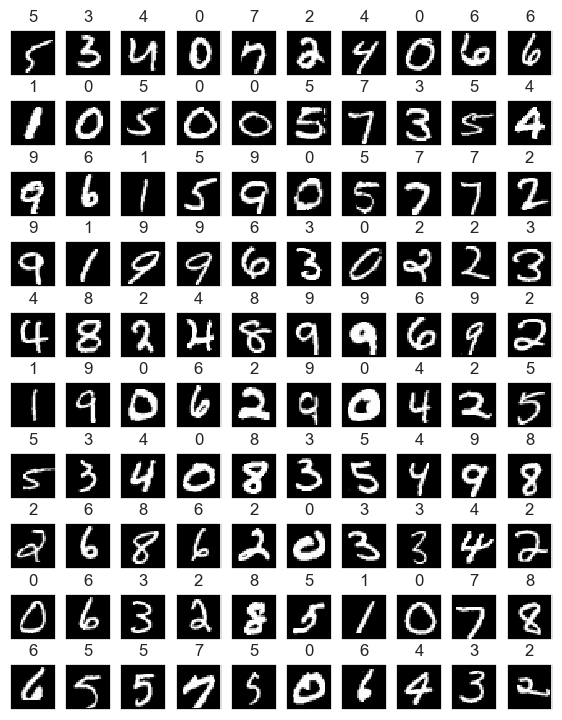

In [6]:
w = 10
fig, ax = plt.subplots(w, w, figsize=(7, 9))
for i in range(w):
  for j in range(w):
    ax[i][j].imshow(instances[i * w + j].permute(1, 2, 0), cmap="gray", interpolation="None")
    label = targets[i * w + j].item()
    ax[i][j].set_title(label)
    ax[i][j].set_xticks([])
    ax[i][j].set_yticks([])

### Funções/Classes Auxiliares

Classe para registramos a loss a cada época

In [10]:
class AverageMeter:
    def __init__(self):
        self.reset()

    def reset(self):
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

Função de treinamento

In [75]:
def train_step(model, train_dl, loss_fn, optimizer, device):
  # ativar modo de treino
  model.train()

  train_loss = AverageMeter()
  for train_instances, instance_labels in train_dl:
    # mover o lote e os rotulos para o mesmo dispositivo do modelo
    train_instances = train_instances.to(device)
    instance_labels = instance_labels.to(device)

    # fazer previsão com o modelo
    logits = model(train_instances)

    # zerar os gradientes para evitar acumular
    optimizer.zero_grad()

    # calcular função de perda
    loss = loss_fn(logits, instance_labels)
    train_loss.update(loss.item(), len(train_instances))

    # backpropagation para obter gradientes
    loss.backward()

    # aplicar a atualização dos parametros da rede baseado nos gradientes
    optimizer.step()
  return train_loss.avg

Função de validação

In [76]:
def validation_step(model, val_dl, loss_fn, device):
  # ativar modo de avaliação
  model.eval()

  val_loss = AverageMeter()
  # desativar computação de gradientes
  with torch.no_grad():
    for val_instances, instance_labels in val_dl:
      # mover o lote e os rotulos para o mesmo dispositivo do modelo
      val_instances = val_instances.to(device)
      instance_labels = instance_labels.to(device)

      # fazer previsão com o modelo
      logits = model(val_instances)

      # calcular função de perda
      loss = loss_fn(logits, instance_labels)
      val_loss.update(loss.item(), len(val_instances))
  return val_loss.avg

Função para realizar o treinamento

In [84]:
def train(model, train_dl, val_dl, loss_fn, optimizer, device, EPOCHS):
  history = {
    "train_loss": [],
    "val_loss": []
  }

  update_graph = EPOCHS//5
  for epoch in range(1, EPOCHS+1):
    train_loss = train_step(model, train_dl, loss_fn, optimizer, device)
    val_loss = validation_step(model, val_dl, loss_fn, device)

    history["train_loss"].append(train_loss)
    history["val_loss"].append(val_loss)

    #if epoch % update_graph == 0:
    if epoch == EPOCHS:
      #print(f"Época [{epoch}/{EPOCHS}]")
      #print("-" * 35)
      print(f"Train loss: {round(train_loss, 6):<7}")
      print(f"Valid. loss: {round(val_loss, 6):<7}\n")
  
  update_graph = EPOCHS//30
  if update_graph < 1:
    update_graph = 1
    
  fig = plt.figure()
  plt.title("Cross entropy loss")
  plt.plot(history["train_loss"][::update_graph], c="g", label="train")
  plt.plot(history["val_loss"][::update_graph], c="r", label="valid")
  plt.legend()

Função para testar o modelo

In [78]:
def test(model, dataset, device):
    all_probs = []
    all_preds = []
    all_targets = []

    total_corrects = 0
    total_n = 0
    model.eval()
    for instances, labels in dataset:
        instances = instances.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            logits = model(instances)
            probabilities = nn.functional.softmax(logits, 1)
            preds = torch.argmax(probabilities, 1)

        total_corrects += (preds == labels).sum().item()
        total_n += len(instances)

        all_preds.append(preds.unsqueeze(-1))
        all_targets.append(labels.cpu())
        all_probs.append(probabilities.cpu())


    preds = torch.cat(all_preds).cpu()
    targets = torch.cat(all_targets).cpu()

    labels = list(str(i) for i in range(10))
    print(classification_report(targets, preds, target_names=labels, zero_division=0, digits=4))
    
    return total_corrects/total_n

In [93]:
def init_weights_he_normal(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def init_weights_he_uniform(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

### Parâmetros e arquitetura inicial

Nessa classe podemos definir uma arquitetura personalizada, botando quantas camadas convolucionais/fully conected quisermos, cada uma personalizada da maneira que quisermos testar, evitando que precisemos definir várias classes diferentes para cada arquitetura que quisermos testar.

In [7]:
class CNN(nn.Module):
  def __init__(self, architecture, in_channels=1):
    super().__init__()
    self.layers = nn.ModuleList()

    for layer in architecture['conv']:
      conv_layer = nn.Conv2d(
        in_channels,
        layer['out_channels'],
        kernel_size=layer['kernel_size'],
        stride=layer['stride'],
        padding=layer['padding']
      )
      self.layers.append(conv_layer)
      
      if 'batch_norm' in layer and layer['batch_norm']:
        self.layers.append(nn.BatchNorm2d(layer['out_channels']))
      if 'activation' in layer:
        self.layers.append(layer['activation']())
      if 'pooling' in layer:
        pool_layer = getattr(nn, layer['pooling']['type'])(**layer['pooling']['params'])
        self.layers.append(pool_layer)
      in_channels = layer['out_channels']
    
    self.flatten = nn.Flatten()
    mlp_input_size = architecture['mlp_input_size']
    self.fc_layers = nn.ModuleList()
    for units in architecture['mlp']:
      self.fc_layers.append(nn.Linear(mlp_input_size, units['out_units']))
      if 'activation' in units:
        self.fc_layers.append(units['activation']())
      if 'dropout' in units:
        self.fc_layers.append(nn.Dropout(units['dropout']))
      mlp_input_size = units['out_units']
    
    self.output_layer = nn.Linear(mlp_input_size, architecture['output_units'])
  
  def forward(self, x):
    for layer in self.layers:
      x = layer(x)

    x = self.flatten(x)
    for layer in self.fc_layers:
      x = layer(x)
    
    x = self.output_layer(x)
    return x

In [68]:
from sklearn.model_selection import ParameterGrid

Função para testar combinações de hiperparâmetros

In [94]:
def hyperparameter_search(train_dl, val_dl, param_grid, device):
    best_params = None
    best_accuracy = 0

    for params in ParameterGrid(param_grid):
        print(f"Testing with parameters: {params}")

        model = CNN(params['architecture']).to(device)
        if 'initialization' in params:
            if params['initialization'] == 'normal':
                model.apply(init_weights_he_normal)
            else:
                model.apply(init_weights_he_uniform)
        optimizer = getattr(optim, params['optimizer'])(model.parameters(), lr=params['learning_rate'])
        loss_fn = nn.CrossEntropyLoss()

        train(model, train_dl, val_dl, loss_fn, optimizer, device, params['epochs'])
        val_accuracy = test(model, val_dl, device)

        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params

    return best_params, best_accuracy

### Teste inicial: achando o otimizador, learning rate e quantidade de épocas

Testing with parameters: {'architecture': {'conv': [{'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 1568, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 15, 'learning_rate': 0.001, 'optimizer': 'SGD'}
Train loss: 0.575705
Valid. loss: 0.39772

              precision    recall  f1-score   support

           0     0.9255    0.9754    0.9498       853
           1     0.9070    0.9606    0.9330      1015
           2     0.8916    0.8740    0.8827       913
           3     0.8647    0.8843    0.8744       925
           4     0.9084    0.8857    0.8969       884
           5     0.8858    0.7797    0.8294       826
    

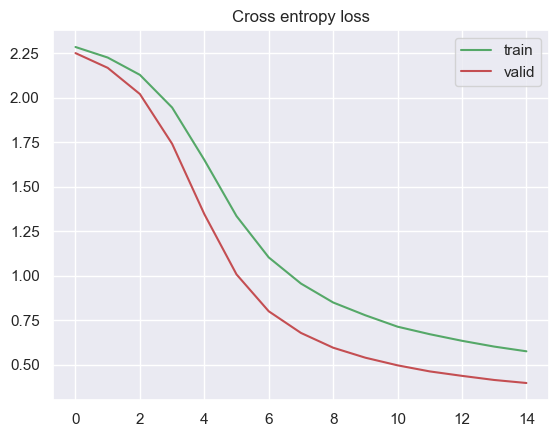

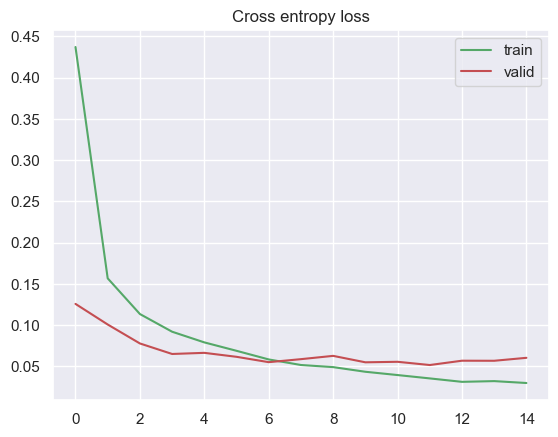

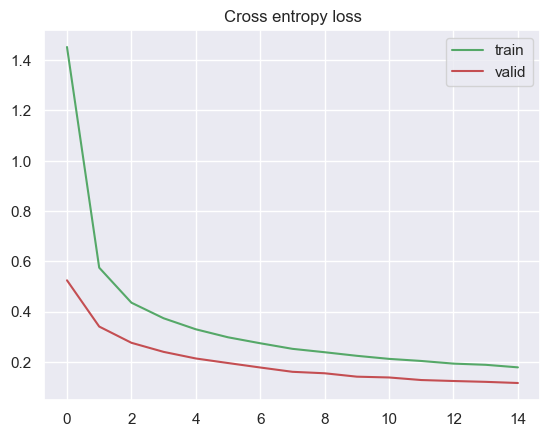

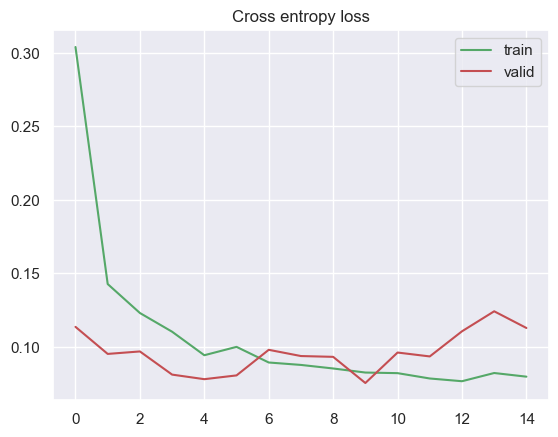

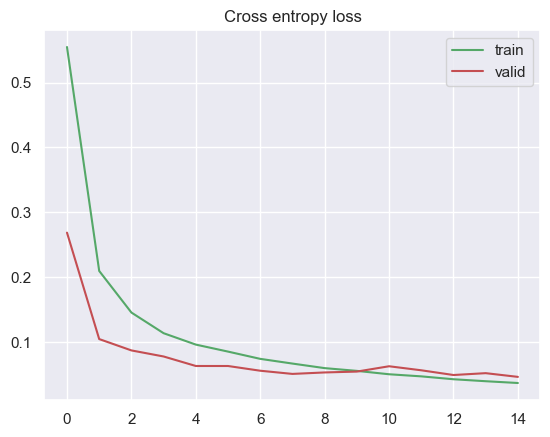

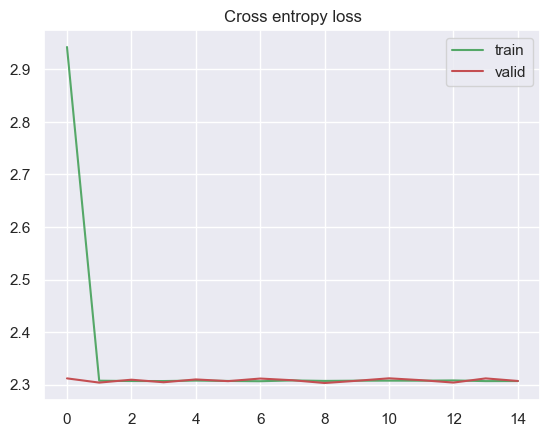

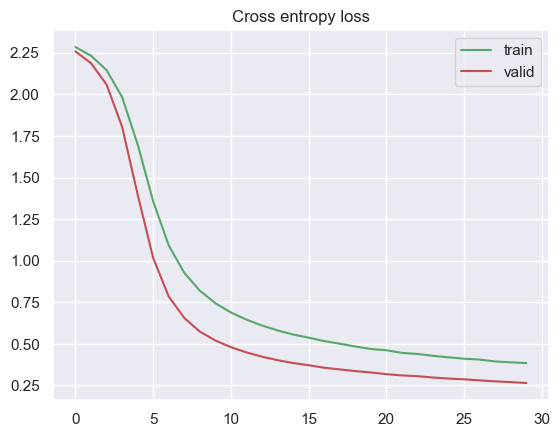

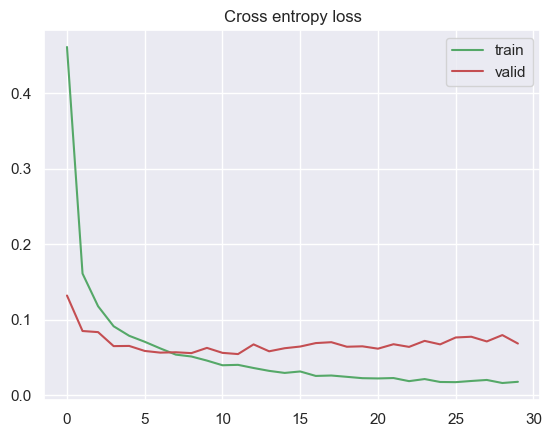

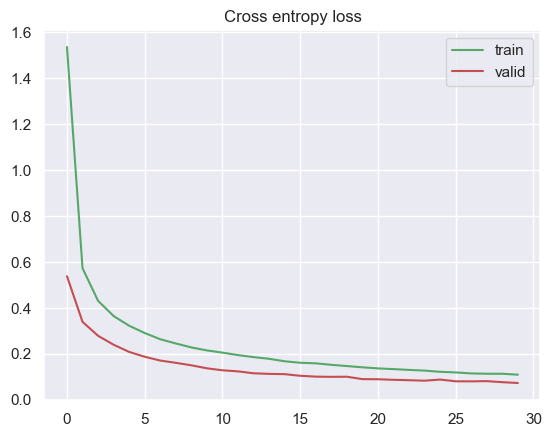

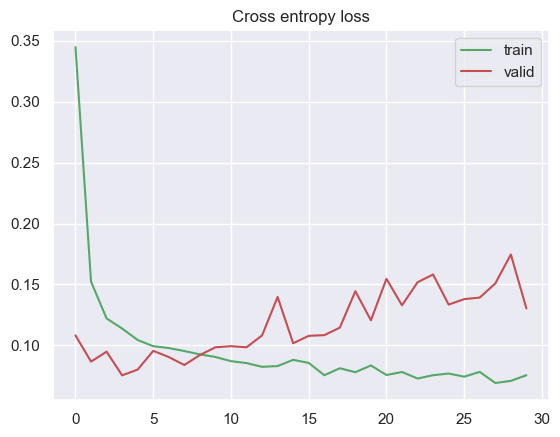

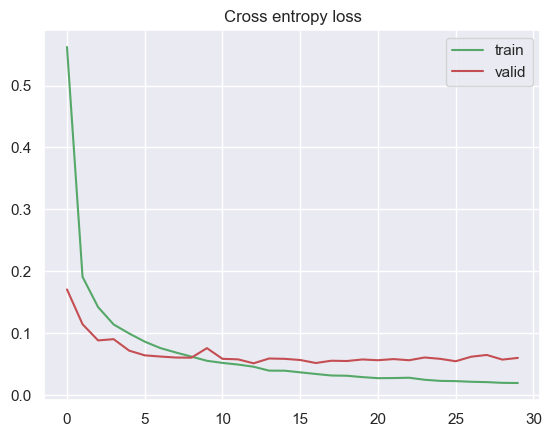

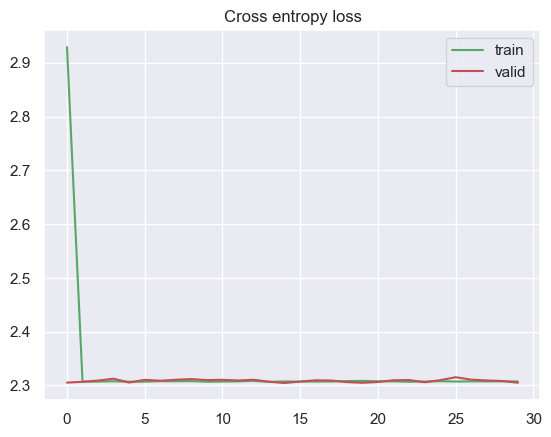

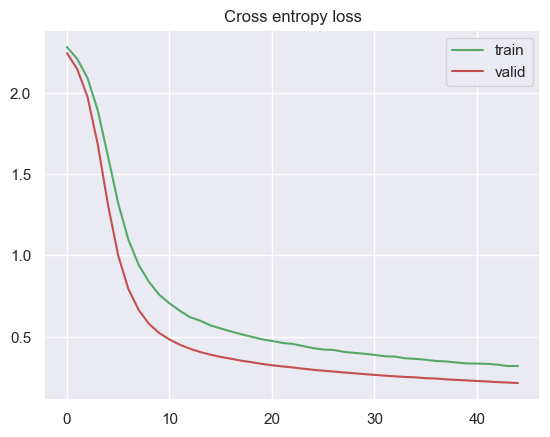

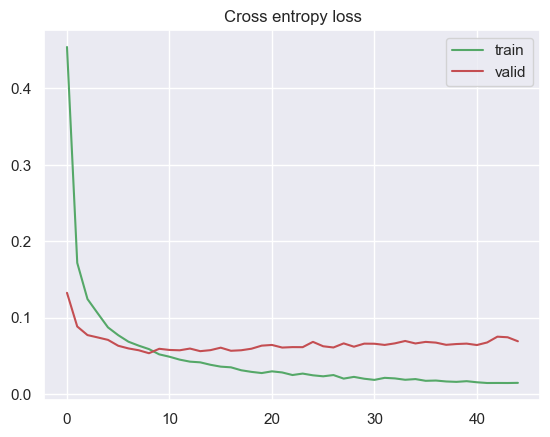

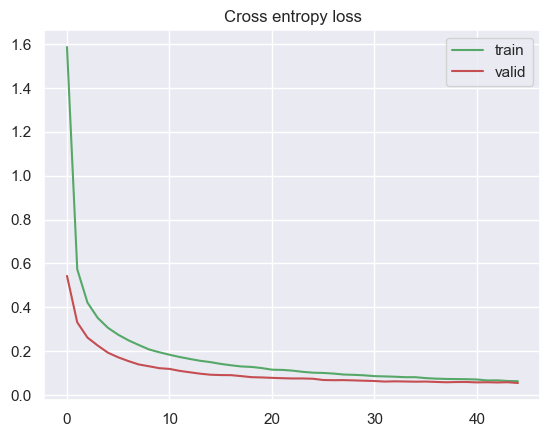

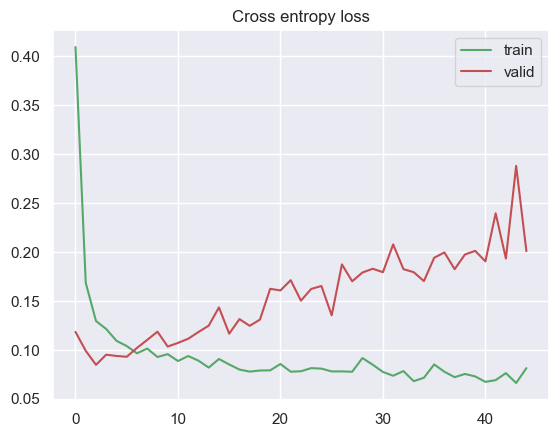

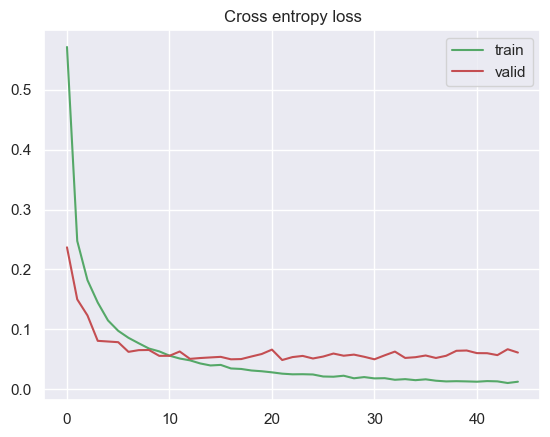

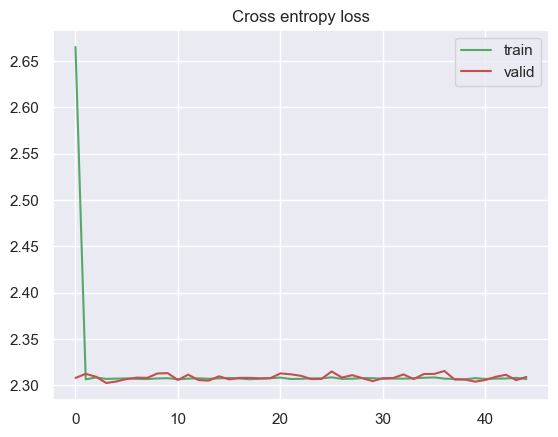

In [86]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001, 0.01, 0.1],
    'optimizer': ['SGD', 'Adam'],
    'epochs': [15, 30, 45]
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Melhores desempenhos:
- SGD, 0.1 lr, 45 épocas (98.84%)
- SGD, 0.1 lr, 15 épocas (98.82%)
- aram, 0.001 lr, 45 épocas (98.66%)
- adam, 0.001 lr, 15/30 épocas (98.51%)


### Teste com inicialização

Testing with parameters: {'architecture': {'conv': [{'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 1568, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 15, 'initialization': 'normal', 'learning_rate': 0.1, 'optimizer': 'SGD'}
Train loss: 0.121436
Valid. loss: 0.109094

              precision    recall  f1-score   support

           0     0.9722    0.9824    0.9773       853
           1     0.9920    0.9734    0.9826      1015
           2     0.9606    0.9617    0.9611       913
           3     0.9553    0.9708    0.9630       925
           4     0.9838    0.9604    0.9720       884
           5     0.9628    0.97

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000017A0444CDC0>
Traceback (most recent call last):
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000017A0444CDC0>
Traceback (most recent call last):
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1479, in __del__
    self._shutdown_workers()
  File "c:\Users\T-Gamer\miniconda3\envs\redesneurais\lib\site-packages\torch\utils\data\dataloader.py", line 1437, in _shutdown_worke

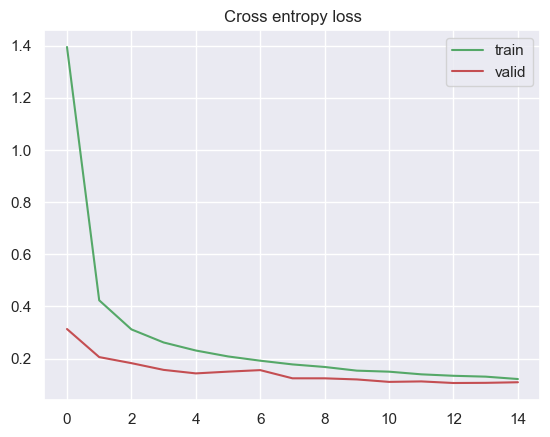

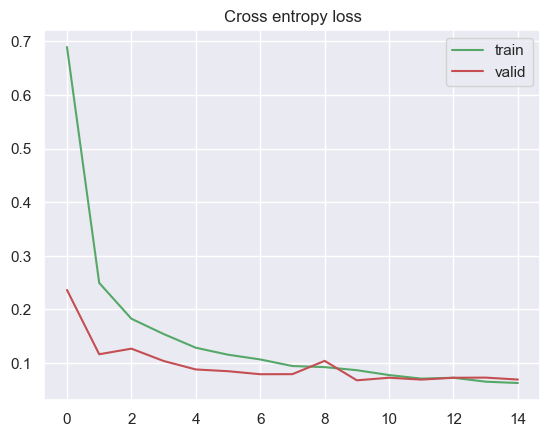

In [95]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.1],
    'optimizer': ['SGD'],
    'epochs': [15],
    'initialization': ['normal', 'uniform']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")

Testing with parameters: {'architecture': {'conv': [{'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}], 'mlp_input_size': 1568, 'mlp': [{'out_units': 128, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}, {'out_units': 64, 'activation': <class 'torch.nn.modules.activation.ReLU'>, 'dropout': 0.3}], 'output_units': 10}, 'epochs': 30, 'initialization': 'normal', 'learning_rate': 0.001, 'optimizer': 'Adam'}
Train loss: 0.026287
Valid. loss: 0.080531

              precision    recall  f1-score   support

           0     0.9907    0.9941    0.9924       853
           1     0.9911    0.9892    0.9901      1015
           2     0.9836    0.9869    0.9852       913
           3     0.9838    0.9870    0.9854       925
           4     0.9875    0.9819    0.9847       884
           5     0.9927    0

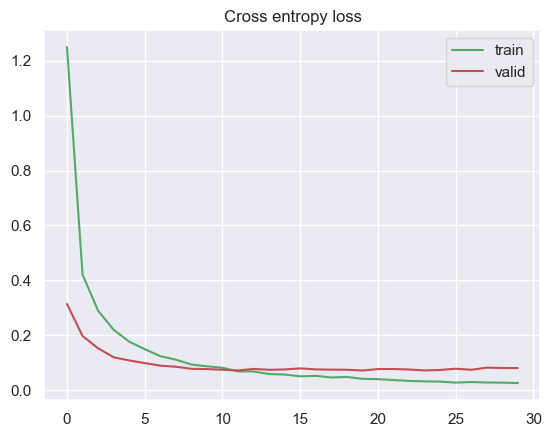

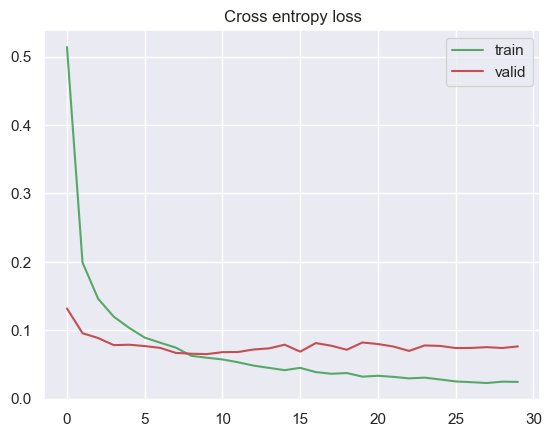

In [96]:
param_grid = {
    'architecture': [
        {
            'conv': [
                {'out_channels': 8, 'kernel_size': 3, 'stride': 1, 'padding': 1, 'activation': nn.ReLU, 'pooling': {'type': 'MaxPool2d', 'params': {'kernel_size': 2, 'stride': 2}}, 'batch_norm': False}
            ],
            'mlp_input_size': 8*14*14,
            'mlp': [
                {'out_units': 128, 'activation': nn.ReLU, 'dropout': 0.3},
                {'out_units': 64, 'activation': nn.ReLU, 'dropout': 0.3}
            ],
            'output_units': 10
        }
    ],
    'learning_rate': [0.001],
    'optimizer': ['Adam'],
    'epochs': [30],
    'initialization': ['normal', 'uniform']
}

best_params, best_accuracy = hyperparameter_search(train_dl, val_dl, param_grid, device)
print(f"Best parameters: {best_params}")
print(f"Best validation accuracy: {best_accuracy:.4f}")